# Hyperparameter optimization

Our dataset is <= 1GB, but there are many hyperparameters to choose from (learning rate, number of layers, layer 
width, etc.).
The Hyperband search from (Li et al., 2016) and implemented in dask-ml (Sievert et al., 2018)
as [HyperbandCV](https://ml.dask.org/modules/generated/dask_ml.model_selection.HyperbandSearchCV.html#dask_ml.model_selection.HyperbandSearchCV)
is designed to handle this exact case: compute but not memory bound hyperparameter optimization


“Hyperband: A novel bandit-based approach to hyperparameter optimization”, 2016 by L. Li, K. Jamieson, G. DeSalvo, A. Rostamizadeh, and A. Talwalkar. https://arxiv.org/abs/1603.06560

“Better and faster hyperparameter optimization with Dask”, 2018 by S. Sievert, T. Augspurger, M. Rocklin. https://doi.org/10.25080/Majora-7ddc1dd1-011

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from scipy.stats import uniform, loguniform
from scikeras.wrappers import KerasRegressor
import dask.array as darray
from dask.distributed import Client, get_client
from dask_ml.model_selection import HyperbandSearchCV

from mlcdc import KerasFeeder, SurfaceFeeder

## Preliminary setup

In [8]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')
ds['log10_atm_tprcp'] = np.log10(ds.atm_tprcp)
ds['atm_speed_srf'] = ds.atm_wind_speed.isel(alev=-1)
ds['ocn_speed_srf'] = ds.ocn_speed.isel(olev=0)
ds['ocn_u_srf'] = ds['ocn_u'].isel(olev=0)
ds['ocn_v_srf'] = ds['ocn_v'].isel(olev=0)
ds['log10_atm_tprcp'].attrs['long_name'] = 'derived log10 of tprcp'
ds['atm_speed_srf'].attrs['long_name'] = 'derived atmospheric surface wind speed'
ds['ocn_speed_srf'].attrs['long_name'] = 'derived ocean surface current speed'
ds['ocn_u_srf'].attrs['long_name'] = 'derived zonal ocean surface current speed'
ds['ocn_v_srf'].attrs['long_name'] = 'derived meridional ocean surface current speed'

ds['ocn_ubtav'] = ds['ocn_ubtav'].isel(olev=0)
ds['ocn_vbtav'] = ds['ocn_vbtav'].isel(olev=0)
ds['ocn_baro_srf'] = np.sqrt(ds.ocn_ubtav**2 + ds.ocn_vbtav**2)
ds['ocn_baro_srf'].attrs['long_name'] = 'derived barotropic ocean current speed'

ds['corr_atm_ocn'] = ds.corr_atm_ocn.isel(olev=0,alev=-1)

In [9]:
features_and_labels = [
    'atm_q2m','atm_qrain','atm_t2m','atm_tprcp','atm_speed_srf',
    'ocn_MEKE', 'ocn_MLD', 'ocn_sfc', 'ocn_sst', 'ocn_speed_srf', 'ocn_baro_srf',
    'corr_atm_ocn',
]

In [10]:
for key in features_and_labels:
    if 'long_name' in ds[key].attrs:
        print(f"{key:<24s}: {ds[key].long_name}")

atm_q2m                 : q2m
atm_qrain               : qrain
atm_t2m                 : t2m
atm_tprcp               : tprcp
atm_speed_srf           : derived atmospheric surface wind speed
ocn_MEKE                : Mesoscale Eddy Kinetic Energy
ocn_MLD                 : Instantaneous active mixing layer depth
ocn_sfc                 : Free surface Height
ocn_sst                 : Sea surface temperature (derived)
ocn_speed_srf           : derived ocean surface current speed
ocn_baro_srf            : derived barotropic ocean current speed


In [11]:
features = features_and_labels.copy()
features.remove('corr_atm_ocn')

In [12]:
kf = SurfaceFeeder(feature_names=features,
                 label_name='corr_atm_ocn',
                 mask_name='ocn_mask',
                 training_fraction=0.8,
                 load_into_memory=True)

In [13]:
kf(ds)

## Setup data in numpy format...

In [14]:
X = np.concatenate([val[...,None] for val in kf.x_training.values()], axis=1)
y = kf.labels['training'].values

## Create the model

Input layers are created in `KerasFeeder`, for simple linear regression, just merge the inputs and feed to output.

In [15]:
def build_model(n_layers=1,
                units_per_layer=16,
                hidden_activation=None,
                regularizer=keras.regularizers.L2,
                regularization=1e-7,
               ):
    
    # hard code this part for now
    ftr = ['atm_q2m', 'atm_qrain', 'atm_t2m','atm_tprcp', 'atm_speed_srf',
           'ocn_MEKE', 'ocn_MLD', 'ocn_sfc', 'ocn_sst', 'ocn_speed_srf', 'ocn_baro_srf']
    
    inputs = keras.Input(shape=(len(ftr,)), name="all_inputs")
    #inputs = [keras.Input(shape=(1,), name=name) for name in ftr]
    
    #hidden = keras.layers.concatenate(inputs)
    for i in range(n_layers):
        this_one = inputs if i == 0 else hidden
        hidden = keras.layers.Dense(
            units=units_per_layer,
            activation=hidden_activation,
            kernel_regularizer=regularizer(regularization),
            bias_regularizer=regularizer(regularization),
        )(this_one)
        
    output = keras.layers.Dense(
        activation='tanh',
        units=1, name='ao_corr'
    )(hidden)
    
    model = keras.Model(
        inputs=inputs,
        outputs=[output]
    )
    
    return model

## Try model already "optimized"

In [16]:
model = KerasRegressor(build_model,
                       # args
                       n_layers=18,
                       units_per_layer=16,
                       hidden_activation="tanh",
                       regularizer=keras.regularizers.L1,
                       regularization=4.092099144907797e-6,
                       # args via scikeras
                       loss=keras.losses.MeanAbsoluteError(),
                       optimizer__learning_rate=0.006760844049883218,
                       batch_size=128,
                       # actual scikeras args
                       optimizer=keras.optimizers.Adam,
                       metrics=["mean_squared_error"],
                       validation_split=0.2,
                       epochs=100,
                      )

In [17]:
%%time
model.fit(X,y)

Epoch 1/100


2022-08-31 12:18:18.339424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


496/496 [==============================] - 3s 3ms/step - loss: 0.0668 - mean_squared_error: 0.0069 - val_loss: 0.0703 - val_mean_squared_error: 0.0074
Epoch 2/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0605 - mean_squared_error: 0.0056 - val_loss: 0.0621 - val_mean_squared_error: 0.0056
Epoch 3/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0581 - mean_squared_error: 0.0052 - val_loss: 0.0566 - val_mean_squared_error: 0.0050
Epoch 4/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0573 - mean_squared_error: 0.0050 - val_loss: 0.0579 - val_mean_squared_error: 0.0049
Epoch 5/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0558 - mean_squared_error: 0.0048 - val_loss: 0.0615 - val_mean_squared_error: 0.0057
Epoch 6/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0555 - mean_squared_error: 0.0048 - val_loss: 0.0549 - val_mean_squared_error: 0.0047
Epoch 7/100
496/496 [=============

496/496 [==============================] - 1s 2ms/step - loss: 0.0464 - mean_squared_error: 0.0034 - val_loss: 0.0472 - val_mean_squared_error: 0.0035
Epoch 52/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0459 - mean_squared_error: 0.0033 - val_loss: 0.0463 - val_mean_squared_error: 0.0033
Epoch 53/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0457 - mean_squared_error: 0.0033 - val_loss: 0.0455 - val_mean_squared_error: 0.0032
Epoch 54/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0459 - mean_squared_error: 0.0033 - val_loss: 0.0462 - val_mean_squared_error: 0.0033
Epoch 55/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0457 - mean_squared_error: 0.0032 - val_loss: 0.0472 - val_mean_squared_error: 0.0033
Epoch 56/100
496/496 [==============================] - 1s 2ms/step - loss: 0.0457 - mean_squared_error: 0.0033 - val_loss: 0.0467 - val_mean_squared_error: 0.0033
Epoch 57/100
496/496 [=======

KerasRegressor(
	model=<function build_model at 0x103f50040>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<class 'keras.optimizers.optimizer_v2.adam.Adam'>
	loss=<keras.losses.MeanAbsoluteError object at 0x149fcfb50>
	metrics=['mean_squared_error']
	batch_size=128
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	n_layers=18
	units_per_layer=16
	hidden_activation=tanh
	regularizer=<class 'keras.regularizers.L1'>
	regularization=4.092099144907797e-06
	optimizer__learning_rate=0.006760844049883218
)

In [18]:
pred = model.predict(np.concatenate([val[...,None] for val in kf.x_testing.values()], axis=1))

155/155 [==============================] - 0s 909us/step


[Text(0.5, 0, 'Truth'), Text(0, 0.5, 'Prediction')]

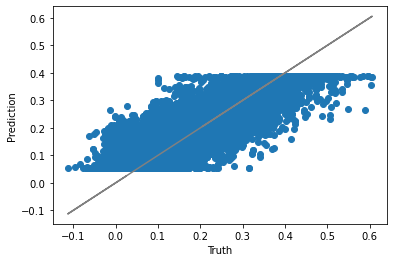

In [19]:
fig, ax = plt.subplots()
ax.scatter(kf.labels['testing'],
           pred,
          )
ax.plot(kf.labels['testing'],
        kf.labels['testing'],
        color='gray')
ax.set(xlabel='Truth',ylabel='Prediction')

In [21]:
model.r_squared(kf.labels['testing'].values[...,None], pred[...,None])

<tf.Tensor: shape=(), dtype=float32, numpy=0.6416687>

## HyperbandCV

Other possible scoring metrics are listed [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [19]:
params = {
    "n_layers" : np.arange(2, 20),
    "units_per_layer" : [8, 16, 32, 64, 128],
    "hidden_activation" : ["tanh", "swish", "sigmoid"],
    "regularizer" : [keras.regularizers.L2,
                     keras.regularizers.L1],
    "regularization" : loguniform(1e-9, 1e-2),
    "optimizer__learning_rate" : loguniform(1e-5, 1e-1),
    "loss" : [keras.losses.MeanAbsoluteError(),
              keras.losses.MeanSquaredError(),
              keras.losses.Huber(delta=10),
              keras.losses.Huber(delta=1),
              keras.losses.Huber(delta=0.1)],
    "batch_size" : [16, 32, 64, 128, 256, 512, 1024],
}

In [20]:
kw = {key : None for key in params.keys()}

In [43]:
modelcv = KerasRegressor(model=build_model,
                         verbose=False,
                         validation_split=0.2,
                         epochs=4,
                         optimizer=keras.optimizers.Adam,
                         metrics=["mean_squared_error"],
                         **kw
                        )

### Get chunksize, as recommended [here](https://ml.dask.org/hyper-parameter-search.html#hyperparameter-hyperband-params)

assuming number of epochs is number of passes through the data...

In [45]:
n_examples = modelcv.epochs * kf.n_samples
n_params = 8

In [46]:
X.shape

(79212, 11)

In [47]:
kf.n_samples

79212

In [48]:
chunk_size = n_examples // n_params
chunk_size

39606

In [49]:
Xc = darray.from_array(X, chunks=(chunk_size, -1))
yc = darray.from_array(y, chunks=(chunk_size,))

In [50]:
chunk_size

39606

In [51]:
Xc

dask.array<array, shape=(79212, 11), dtype=float64, chunksize=(39606, 11), chunktype=numpy.ndarray>

In [22]:
HyperbandSearchCV?

In [53]:
search = HyperbandSearchCV(
    estimator=modelcv,
    parameters=params,
    max_iter=n_params,
    tol=1e-3,
    patience=20,
    test_size=0.2,
    random_state=0,
    scoring=["neg_mean_squared_error"],
)

In [54]:
try:
    client = get_client()
    client.restart()
except ValueError:
    client = Client()

In [ ]:
%%time
search.fit(X, y)

2022-08-30 17:42:40.146275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 17:42:40.147228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 17:42:44.766460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-08-30 17:42:54,452 - distributed.core - ERROR - Exception while handling op get_data
Traceback (most recent call last):
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/core.py", line 769, in _handle_comm
    result = await result
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/worker.py", line 1693, in get_data
    assert response == "OK", response
AssertionError: {'op': 'get_data', 'keys': {'finalize-45551b67fb7ec6f460d4f413c82ff35d', 'finalize-f20cd00f383e7122d4f3e02c5ff56326', '_partial_fit-52749477-512b-4c38-bf9f-0633b884ab1b'}, 'who': 'tcp://127.0.0.1:55508', 'max_connections': None, 'reply': True}
2022-08-30 17:42:59,097 - distributed.worker - ERROR - {'op': 'get_data', 'keys': {'_partial_fit-52749477-512b-4c38-bf9f-0633b884ab1b', 'finalize-45551b67fb7ec6f460d4f413c82ff35d', 'finalize-f20cd00f383e7122d4f3e02c5ff56326'}, 'who': 'tcp://127.0.0.1:55508', 'max_connections': None, 'reply': True}
Traceback (most rec

2022-08-30 17:43:10,406 - distributed.worker - ERROR - Could not serialize object of type KerasRegressor
Traceback (most recent call last):
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/serialize.py", line 347, in serialize
    header, frames = dumps(x, context=context) if wants_context else dumps(x)
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/serialize.py", line 71, in pickle_dumps
    frames[0] = pickle.dumps(
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/pickle.py", line 58, in dumps
    result = cloudpickle.dumps(x, **dump_kwargs)
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/cloudpickle/cloudpickle_fast.py", line 633, in dump
    return Pickler.dump(self, obj)
  File "/Users/tsmith/.conda/en

2022-08-30 17:43:13,908 - distributed.core - ERROR - Exception while handling op get_data
Traceback (most recent call last):
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/core.py", line 769, in _handle_comm
    result = await result
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/worker.py", line 1693, in get_data
    assert response == "OK", response
AssertionError: {'op': 'get_data', 'keys': {'_partial_fit-932c26a7-2840-4da5-9f0d-105afbebf4e7'}, 'who': 'tcp://127.0.0.1:55508', 'max_connections': None, 'reply': True}
2022-08-30 17:43:16,141 - distributed.worker - ERROR - {'op': 'get_data', 'keys': {'_partial_fit-932c26a7-2840-4da5-9f0d-105afbebf4e7'}, 'who': 'tcp://127.0.0.1:55508', 'max_connections': None, 'reply': True}
Traceback (most recent call last):
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/worker.py", line 1983, in gather_dep
    response = await get_data_from_worker(
  F

2022-08-30 17:43:29,158 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/core.py", line 158, in loads
    return msgpack.loads(
  File "msgpack/_unpacker.pyx", line 194, in msgpack._cmsgpack.unpackb
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/core.py", line 138, in _decode_default
    return merge_and_deserialize(
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/serialize.py", line 497, in merge_and_deserialize
    return deserialize(header, merged_frames, deserializers=deserializers)
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/serialize.py", line 410, in deserialize
    deserialize(
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/serialize.py", line 426, in deserialize
    ret

2022-08-30 17:44:03,249 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/core.py", line 158, in loads
    return msgpack.loads(
  File "msgpack/_unpacker.pyx", line 194, in msgpack._cmsgpack.unpackb
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/core.py", line 138, in _decode_default
    return merge_and_deserialize(
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/serialize.py", line 497, in merge_and_deserialize
    return deserialize(header, merged_frames, deserializers=deserializers)
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/serialize.py", line 410, in deserialize
    deserialize(
  File "/Users/tsmith/.conda/envs/mlcdc/lib/python3.10/site-packages/distributed/protocol/serialize.py", line 426, in deserialize
    ret

2022-08-30 17:44:09.915277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
best = search.best_estimator_

In [ ]:
pred = best.predict(np.concatenate([val[...,None] for val in kf.x_testing.values()], axis=1))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(kf.labels['testing'],
           pred,
          )
ax.plot(kf.labels['testing'],
        kf.labels['testing'],
        color='gray')
ax.set(xlabel='Truth',ylabel='Prediction')

In [47]:
best.r_squared(kf.labels['testing'].values[...,None], pred[...,None])

NameError: name 'best' is not defined

In [113]:
search.best_params_

{'batch_size': 256,
 'hidden_activation': 'swish',
 'learning_rate': 0.023826650493636626,
 'n_layers': 5,
 'regularization': 0.0008526330668991535,
 'regularizer': keras.regularizers.L1,
 'units_per_layer': 32}